In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import concurrent

from bayegent import Bayegent
from environment import GridMazeEnvironment

ModuleNotFoundError: No module named 'bayegent'

In [ ]:
def run_one_seed(seed, parameters, n_runs=100):
    environment = GridMazeEnvironment(seed)
    agent = Bayegent(environment, seed, parameters=parameters)

    all_position_histories = agent.learn_bayesian(n_runs)

    return all_position_histories


In [3]:
def run_experiment(lr_interval, df_interval, curiosity_interval=(0.2,0.9), gridsize=10, n_runs=100):
    # Constants
    curiosities = list(reversed(np.linspace(curiosity_interval[0],curiosity_interval[1],n_runs)))


    # Param search over learning rates and discount factors
    learning_rates = list(reversed(np.linspace(lr_interval[0],lr_interval[1],gridsize)))
    discount_factors = list(reversed(np.linspace(lr_interval[0],lr_interval[1],gridsize)))

    last_path_lengths = {lr: {df: 0 for df in discount_factors} for lr in learning_rates}
    min_path_lengths = {lr: {df: 0 for df in discount_factors} for lr in learning_rates}
    running_times_weaning = {lr: {df: 0 for df in discount_factors} for lr in learning_rates}

    # Iterate over 100 seeds
    for lr in learning_rates:
        for df in discount_factors:
            print(f'LR: {lr}, DF: {df}')
            for seed in range(50):
                print(f'{seed}/50')
                start = time.time()
                position_histories = run_one_seed(seed, 
                                                parameters={
                                                    'curiosity': curiosities,
                                                    'step_reward': -0.1,
                                                    'goal_reward': 1,
                                                    'learning_rate': lr, # 0.5
                                                    'discount_factor': df, # 0.8
                                                },
                                                n_runs=n_runs)
                end = time.time()

                path_lengths = [len(pl) for pl in position_histories]

                running_times_weaning[lr][df] = end-start
                last_path_lengths[lr][df] = path_lengths[-1]
                min_path_lengths[lr][df] = min(path_lengths)

    return last_path_lengths, min_path_lengths, running_times_weaning

In [8]:
last_path_lengths, min_path_lengths, running_times_weaning = run_experiment((0.3,0.9), (0.3,0.8), gridsize=7)

LR: 0.9, DF: 0.9
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
LR: 0.9, DF: 0.8
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
LR: 0.9, DF: 0.7000000000000001
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50


KeyboardInterrupt: 

In [19]:
# Function to run one combination of lr and df
def run_one_combination(curiosities, lr, df, n_runs=100):
    print(f'LR: {lr}, DF: {df}')
    start = time.time()
    for seed in range(50):
        print(f'{seed}/50')
        position_histories = run_one_seed(seed, 
                                            parameters={
                                                'curiosity': curiosities,
                                                'step_reward': -0.1,
                                                'goal_reward': 1,
                                                'learning_rate': lr,
                                                'discount_factor': df,
                                            },
                                            n_runs=n_runs)
    end = time.time()

    path_lengths = [len(pl) for pl in position_histories]
    return lr, df, path_lengths, end-start

def run_experiment(lr_interval, df_interval, curiosity_interval=(0.2,0.9), gridsize=10, n_runs=100):
    curiosities = list(reversed(np.linspace(curiosity_interval[0], curiosity_interval[1], n_runs)))
    learning_rates = list(reversed(np.linspace(lr_interval[0], lr_interval[1], gridsize)))
    discount_factors = list(reversed(np.linspace(df_interval[0], df_interval[1], gridsize)))

    # Dictionaries to store results
    last_path_lengths = {lr: {df: 0 for df in discount_factors} for lr in learning_rates}
    min_path_lengths = {lr: {df: 0 for df in discount_factors} for lr in learning_rates}
    running_times = {lr: {df: 0 for df in discount_factors} for lr in learning_rates}

    # Use ProcessPoolExecutor to parallelize
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(run_one_combination, curiosities, lr, df) for lr in learning_rates for df in discount_factors]

        for future in concurrent.futures.as_completed(futures):
            lr, df, path_lengths, run_time = future.result()
            running_times[lr][df] = run_time
            last_path_lengths[lr][df] = path_lengths[-1]
            min_path_lengths[lr][df] = min(path_lengths)

    return last_path_lengths, min_path_lengths, running_times

In [20]:
last_path_lengths, min_path_lengths, running_times_weaning = run_experiment((0.3,0.8), (0.3,0.8), gridsize=7)

Process SpawnProcess-41:
Traceback (most recent call last):
  File "/Users/kam/.pyenv/versions/3.10.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/kam/.pyenv/versions/3.10.10/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/kam/.pyenv/versions/3.10.10/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/kam/.pyenv/versions/3.10.10/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'run_one_combination' on <module '__main__' (built-in)>
Process SpawnProcess-42:
Traceback (most recent call last):
  File "/Users/kam/.pyenv/versions/3.10.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/kam/.pyenv/versions/3.10.10/lib/python3.10/multiprocessing/process.p

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [5]:
import pickle

In [6]:
with open('min_path_lengths_lrdf.pkl', 'rb') as pf:
    min_path_lengths = pickle.load(pf)

[0.8, 0.7166666666666666, 0.6333333333333333, 0.55, 0.4666666666666667, 0.3833333333333333, 0.3]
[0.8, 0.7166666666666666, 0.6333333333333333, 0.55, 0.4666666666666667, 0.3833333333333333, 0.3]
[[23. 25. 25. 23. 23. 23. 25.]
 [25. 23. 23. 23. 25. 25. 25.]
 [20. 43. 22. 37. 20. 22. 39.]
 [20. 20. 20. 24. 22. 51. 25.]
 [24. 20. 20. 35. 22. 41. 24.]
 [22. 20. 35. 35. 33. 22. 47.]
 [20. 20. 24. 29. 20. 43. 24.]]


Text(0.5, 1.0, 'Shortest path=20')

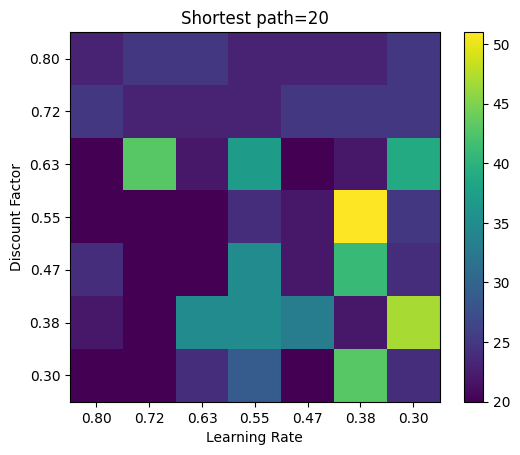

In [8]:
shortest_path = 20

lr_values = list(min_path_lengths.keys())
df_values = list(min_path_lengths[0.8].keys())

grid = np.zeros((len(lr_values), len(df_values)))
for i, lr in enumerate(lr_values):
    for j, df in enumerate(df_values):
        grid[i][j] = min_path_lengths[lr][df]

print(lr_values)
print(df_values)
print(grid)

plt.imshow(grid)
plt.colorbar()
plt.xticks(range(len(lr_values)), labels=["{:.2f}".format(lr) for lr in lr_values])
plt.xlabel('Learning Rate')
plt.yticks(range(len(df_values)), labels=["{:.2f}".format(df) for df in df_values])
plt.ylabel('Discount Factor')

plt.title(f'Shortest path={shortest_path}')